In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utility import *
import seaborn as sns
import statsmodels.api as sm
import pickle
from scipy.io import loadmat
import seaborn as sns
from scipy.stats import pearsonr
pd.set_option('display.float_format', lambda x: '%.5f' % x)
%matplotlib inline

In [2]:
from importlib import reload
import utility
reload(utility)
from utility import *

In [3]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style(style='white') 

In [4]:
sourcefolder='/Users/yyu/Documents/Psychology/Derek/Data/'

# load parcel -> network assignment

In [6]:
parcel=pd.read_excel(sourcefolder+'Parcels.xlsx',sheet_name='Parcels.txt')
parcel['node']=parcel['ParcelID']-1 # use node and Community Column
comdict=parcel.groupby('Community')['node'].apply(list).to_dict()
comlist=parcel['Community'].values
parcel=parcel.sort_values('Community')
#parcel=parcel[~parcel['Community'].isin(['SMhand','SMmouth'])]
nodereorder=parcel['node'].values
commindex=parcel.groupby('Community').count()['node']
labels=commindex.index.values
ticks=commindex.cumsum().values


In [7]:
#reorder and rename for display
nodereorder=[]
labels=[]
comindex=[]

for key in labeldict.keys():
    if key=='None':continue
    
    tmp=parcel[parcel['Community']==key]['node']
    nodereorder=np.concatenate((nodereorder,tmp.values))
    labels.append(labeldict[key])
    comindex.append(len(tmp))
                       
commindex=parcel.groupby('Community').count()['node']
ticks=np.array([sum(comindex[0:x+1]) for x in range(len(comindex))])
labels=np.array(labels)


In [8]:
#9 subjects in MSC, sub08 was excluded
sublist=['01','02','03','04','05','06','07','09','10']

# Functions

In [80]:
#cov of residual is 1/T(y'(I-X(X'X)^(-1)X')y)
def computResidualCov(X,y,n):
    if len(X)==0:
        return np.trace(y.T.dot(y))
    else:
        return np.trace(y.T.dot(np.identity(n)-X.dot(np.linalg.inv(X.T.dot(X))).dot(X.T)).dot(y))
def getVar(thissession,thisedge,nb):
    nb1=nb[thisedge[0]]
    nb2=nb[thisedge[1]]
    sharednb=np.intersect1d(nb1,nb2)
        
    sharedData=thissession[:,sharednb]
    unshared1=thissession[:,np.setdiff1d(nb1,sharednb)]
    unshared2=thissession[:,np.setdiff1d(nb2,sharednb)]
    
    n=max(np.shape(sharedData)[0],np.shape(unshared1)[0],np.shape(unshared2)[0])
    sharedVar=np.trace(sharedData.T.dot(sharedData))
    res1Var=computResidualCov(sharedData,unshared1,n)
    res2Var=computResidualCov(sharedData,unshared2,n)
    return (sharedVar/n,res1Var/n,res2Var/n)
    
def filterOutlier(series):
    mean=series.mean()
    std=series.std()
    return 10*std*np.tanh((series-mean)/std/10)+mean
def regressFlexModel(edgeData):
    explainvar=[]
    paramsPlaceholder=[0,0,0]
    fullExplainVar=['sharedVar_chg','unshared1_chg','unshared2_chg']
    for var in fullExplainVar:
        if np.std(edgeData[var])>0:
            explainvar.append(var)
    model=sm.OLS(edgeData['corr_chg'],edgeData[explainvar])
    try:
        results=model.fit()
        rsquare=results.rsquared
        rsquare_adj=results.rsquared_adj
        paramsDict=dict(zip(explainvar,list(results.params.values)))
        params=[(paramsDict[x] if x in explainvar else 0) for x in fullExplainVar]
    except:
        rsquare=np.nan
        params=[np.nan,np.nan,np.nan]
    return rsquare,rsquare_adj,params

# resting state (baseline) analysis

In [159]:
totalNodes=333
filteredTS = loadmat(sourcefolder+'FilteredTStest.mat')
#filteredTS contain all cleaned BOLD data after tssk design residualized

In [161]:
#example of running for one participant
subindex=5
subid=sublist[subindex]
print(subid)

sparsity=.05 #sparsity for selecting network edge, alternatively sparsity=.1, or 10%
nb = getNeighborNodes(subid, sparsity, sign=0)

#get task data
filtered=filteredTS['TimeFiltered_Rest_TimeSeries'][subindex]
allData=[]
for session in range(10): #10 scan session for resting states
    thissession=filtered[session]
    thissession=thissession - np.mean(thissession,axis=0)[np.newaxis,:]
    corrMatrix=np.corrcoef(thissession.T)
    np.shape(corrMatrix)
    for i in range(totalNodes):
        for j in nb[i]:
            if j<i: continue
            thisedge=(i,j)
            (sharedVar,unshared1,unshared2)=getVar(thissession,thisedge,nb)
            thisCorr=corrMatrix[thisedge[0],thisedge[1]]
            allData.append([i,j,thisCorr,sharedVar,unshared1,unshared2,session])

In [162]:
allData=pd.DataFrame(allData,columns=['i','j','corr','sharedVar','unshared1','unshared2','session'])
allData['corr']=np.arctanh(allData['corr'])
allData.describe()

,i,j,corr,sharedVar,unshared1,unshared2,session
count,110560.00000,110560.00000,110560.00000,110560.00000,110560.00000,110560.00000,110560.00000
mean,109.34171,213.82932,0.19332,244.29368,76.10550,75.89524,4.50000
std,79.67550,79.03822,0.40089,131.29180,61.95155,59.67729,2.87229
min,0.00000,1.00000,-1.25104,0.00000,0.01477,0.00393,0.00000
25%,43.00000,160.00000,-0.21029,142.14168,32.98525,34.38944,2.00000
50%,93.00000,227.00000,0.29103,229.21215,60.12306,61.41290,4.50000
75%,167.00000,270.00000,0.47054,327.09685,101.60903,100.38197,7.00000
max,331.00000,332.00000,1.88091,936.03771,927.80147,624.99559,9.00000


In [163]:
#then run this!!
meancorr=pd.DataFrame(allData.groupby(['i','j']).mean()[['corr','sharedVar','unshared1','unshared2']]).reset_index()
meancorr.rename(columns={'corr':'corrM','sharedVar':'sharedVarM','unshared1':'unshared1M','unshared2':'unshared2M'},inplace=True)
allData=allData.merge(meancorr,left_on=['i','j'],right_on=['i','j'],how='left')
allData['corr_chg']=np.sign(allData['corrM'])*(allData['corr']-allData['corrM'])
allData['sharedVar_chg']=allData['sharedVar']-allData['sharedVarM']
allData['unshared1_chg']=allData['unshared1']-allData['unshared1M']
allData['unshared2_chg']=allData['unshared2']-allData['unshared2M']

In [164]:
#run regression of FC against shared/unshared input variance for each edge
baseModel=[]
for i,g in allData.groupby(['i','j']):
    average=g.mean()
    rsquare,rsquare_adj,params=regressFlexModel(g)
    baseModel.append([i[0],i[1]]+params+[rsquare,rsquare_adj]+
                         list(average[['corrM','sharedVarM','unshared1M','unshared2M']].values))

   

In [165]:
baseModel=pd.DataFrame(baseModel,columns=['i','j','beta_share','beta_un1','beta_un2','rsquare','rsquare_adj','corr_mean',\
                                          'sharedVar_mean','unshared1_mean','unshared2_mean'])
for col in ['beta_share','beta_un1','beta_un2']:
    baseModel[col]=filterOutlier(baseModel[col])
for col in ['beta_share','beta_un1','beta_un2']:
    baseModel[col]=filterOutlier(baseModel[col])

In [42]:
baseModel.to_csv(sourcefolder+'processed/rest_InputRegress_'+subid+'.csv',index=False)
baseModel.describe()

,i,j,beta_share,beta_un1,beta_un2,rsquare,rsquare_adj,corr_mean,sharedVar_mean,unshared1_mean,unshared2_mean
count,11056.00000,11056.00000,11056.00000,11056.00000,11056.00000,11056.00000,11056.00000,11056.00000,11056.00000,11056.00000,11056.00000
mean,112.30436,217.77144,0.00277,-0.00213,-0.00363,0.47211,0.24611,0.11705,217.00139,47.85926,46.41415
std,80.05713,80.37809,0.00590,0.03771,0.04027,0.22048,0.31478,0.42194,114.81741,46.43035,43.45110
min,0.00000,1.00000,-0.05711,-0.36307,-0.41991,0.00108,-0.42702,-0.79183,0.00000,0.21495,0.16765
25%,43.00000,159.00000,0.00079,-0.01356,-0.01483,0.30246,0.00399,-0.31614,125.02441,17.91687,18.45293
50%,98.00000,233.00000,0.00178,-0.00177,-0.00275,0.47677,0.25252,0.29320,213.95300,33.29780,33.22171
75%,169.00000,278.00000,0.00324,0.00967,0.00798,0.64423,0.49175,0.43142,301.63735,60.80009,58.88058
max,330.00000,332.00000,0.06308,0.35914,0.41437,0.98330,0.97614,1.38439,601.11297,543.80647,458.22315


Text(0.5, 1.0, '06')

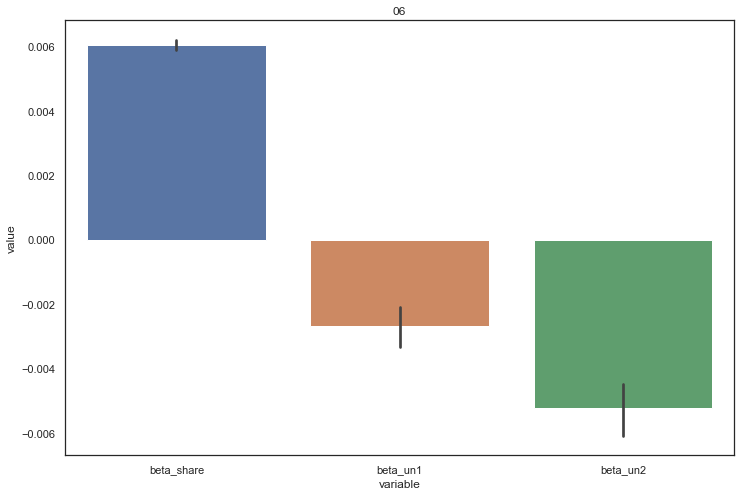

In [10]:
ax=sns.barplot(data=pd.melt(baseModel,id_vars=['i','j'],value_vars=['beta_share','beta_un1','beta_un2']),
           x='variable',y='value',ci=68)
ax.set_title('06')

In [176]:
#plot group data 
alldata=pd.DataFrame()
for subid in sublist:
    baseModel=pd.read_csv(sourcefolder+'processed/rest_InputRegress_'+subid+'_10pct.csv')
    alldata=pd.concat([alldata,baseModel])


Text(0.5, 1.0, 'group')

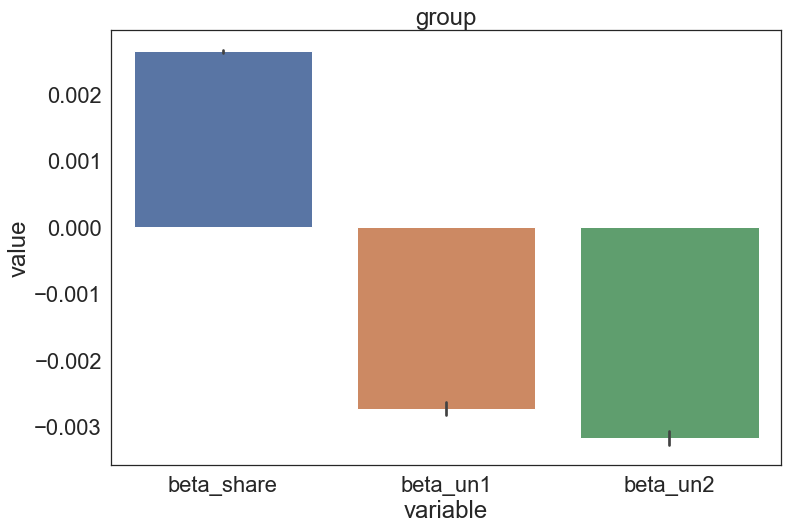

In [171]:
ax=sns.barplot(data=pd.melt(alldata,id_vars=['i','j'],value_vars=['beta_share','beta_un1','beta_un2']),
           x='variable',y='value',ci=68)
ax.set_title('group')

# Task analysis

In [185]:
#for each task type and edge,
#compute communication change by subtracting the product of sensitivty (estimated from rest state) and 
#input variance change from the FC change
totalNodes=333
sparsity=.05 #or .1 for sparsity
for subid in sublist:
    nb = getNeighborNodes(subid, sparsity, sign=0)
    #baseModel=pd.read_csv(sourcefolder+'processed/rest_InputRegress_'+subid+'_10pct.csv',index_col=None)
    baseModel=pd.read_csv(sourcefolder+'processed/rest_InputRegress_'+subid+'.csv',index_col=None)
    for task in ['Motor','Mixed','Rest','Mem']:
        print(task)
        if task=='Mixed':
            filtered_c=filteredTS['TimeFiltered_Coher_TimeSeries'][subindex]
            filtered_s=filteredTS['TimeFiltered_Semantic_TimeSeries'][subindex]
            filtered=np.array([np.vstack((filtered_s[j],filtered_c[j])) for j in range(10)])
        else:
            filtered=filteredTS['TimeFiltered_'+task+'_TimeSeries'][subindex]
        allData=[]
        for session in range(10):
            thissession=filtered[session]
            thissession=thissession - np.mean(thissession,axis=0)[np.newaxis,:]
            corrMatrix=np.corrcoef(thissession.T)

            for i in range(totalNodes):
                for j in nb[i]:
                    if j<i: continue
                    thisedge=(i,j)
                    try:
                        (sharedVar,unshared1,unshared2)=getVar(thissession,thisedge,nb)
                        thisCorr=corrMatrix[thisedge[0],thisedge[1]]
                        allData.append([i,j,thisCorr,sharedVar,unshared1,unshared2,session])
                    except:
                        pass
        allData=pd.DataFrame(allData,columns=['i','j','corr','sharedVar','unshared1','unshared2','session'])
        allData['corr']=np.arctanh(allData['corr'])
        #filter outliers
        for i,g in allData.groupby(['i','j']):
            for col in ['sharedVar','unshared1','unshared2']:
                q=g[col].quantile([.2,.5,.8]).values
                interquantile=q[2]-q[0]
                tmp=g[np.abs(g[col]-q[1])>5*interquantile]
                #remove outliers
                if len(tmp)>0:
                    allData.loc[(allData['session'].isin(tmp['session']))&(allData['i']==i[0])&(allData['j']==i[1]),
                                ['sharedVar','unshared1','unshared2']]=np.nan
        allData=allData.merge(baseModel,how='left',left_on=['i','j'],right_on=['i','j'])
        allData['corr_chg']=np.sign(allData['corr_mean'])*(allData['corr']-allData['corr_mean'])
        allData['comm_chg']=allData['corr_chg']-(allData['beta_share']*(allData['sharedVar']-allData['sharedVar_mean'])+\
                                        allData['beta_un1']*(allData['unshared1']-allData['unshared1_mean'])+\
                                        allData['beta_un2']*(allData['unshared2']-allData['unshared2_mean']))
        print(allData.describe())
        allData.to_csv(sourcefolder+'processed/'+task+'_'+subid+'_comm.csv',index=False)
        #allData.to_csv(sourcefolder+'processed/'+task+'_'+subid+'_comm_10pct.csv',index=False)

0.21276340165884974
Motor
                 i            j         corr    sharedVar    unshared1  \
count 110560.00000 110560.00000 110560.00000 109932.00000 109932.00000   
mean     111.05626    215.48860      0.12345     84.60434     15.97770   
std       79.39290     79.90243      0.36220     47.35326     20.05668   
min        0.00000      3.00000     -1.36644      0.00000   -327.59026   
25%       45.00000    162.00000     -0.12588     49.87857      3.34535   
50%       94.00000    226.00000      0.10495     77.01900      9.45675   
75%      169.00000    275.00000      0.35621    111.45450     20.70443   
max      331.00000    332.00000      2.02624    385.46260    292.32789   

         unshared2      session   beta_share     beta_un1     beta_un2  \
count 109932.00000 110560.00000 110560.00000 110560.00000 110560.00000   
mean      16.08584      4.50000      0.00533     -0.00422     -0.00493   
std       19.88009      2.87229      0.00860      0.04117      0.04071   
min     -20

0.21354363346341312
Motor
                 i            j         corr    sharedVar    unshared1  \
count 110560.00000 110560.00000 110560.00000 106266.00000 106266.00000   
mean     110.78500    214.24846      0.13615    104.87271     10.50252   
std       78.44885     79.22955      0.36287     66.41706     20.85348   
min        0.00000      1.00000     -1.15269      0.00000   -635.38175   
25%       45.00000    161.00000     -0.11683     53.31560      0.76452   
50%       95.00000    226.00000      0.12551     92.47131      3.75250   
75%      167.00000    272.00000      0.37450    142.96279     12.02167   
max      331.00000    332.00000      2.02624    426.29773    386.08168   

         unshared2      session   beta_share     beta_un1     beta_un2  \
count 106266.00000 110560.00000 110560.00000 110560.00000 110560.00000   
mean      10.12638      4.50000      0.00307     -0.00607     -0.00631   
std       19.25656      2.87229      0.00681      0.04284      0.04230   
min     -65

0.20974371729241534
Motor
                 i            j         corr    sharedVar    unshared1  \
count 110560.00000 110560.00000 110560.00000 109105.00000 109105.00000   
mean     111.08656    213.45016      0.12288     83.80167     16.00573   
std       78.43243     79.57477      0.35753     49.88087     21.46474   
min        0.00000      1.00000     -1.36644      0.00000   -170.40120   
25%       47.00000    156.00000     -0.12418     46.68901      2.87670   
50%       96.00000    229.00000      0.10295     75.45135      8.74216   
75%      166.00000    274.00000      0.35244    112.03867     20.78155   
max      331.00000    332.00000      2.02624    377.82821    365.30981   

         unshared2      session   beta_share     beta_un1     beta_un2  \
count 109105.00000 110560.00000 108450.00000 108450.00000 108450.00000   
mean      14.78101      4.50000      0.00307     -0.00311     -0.00258   
std       19.71460      2.87229      0.00711      0.02477      0.03087   
min     -21

### gather saved communication results from previous step

In [199]:
allTaskDF=pd.DataFrame()
for task in ['Mem','Motor','Rest','Mixed']:
    for subid in sublist:
        tmp=pd.read_csv(sourcefolder+'processed/'+task+'_'+subid+'_comm.csv')
        tmp['task']=task
        tmp['id']=subid
        allTaskDF=pd.concat([allTaskDF,tmp])
allTaskDF['predict']=allTaskDF['corr_chg']-allTaskDF['comm_chg']


In [200]:
#the motor sessions from sub09 are bad
allTaskDF=allTaskDF[~((allTaskDF['id']=='09')&(allTaskDF['task']=='Motor'))]
allTaskDF.describe()

,i,j,corr,sharedVar,unshared1,unshared2,session,beta_share,beta_un1,beta_un2,rsquare,corr_mean,sharedVar_mean,unshared1_mean,unshared2_mean,corr_chg,comm_chg,predict
count,1934800.00000,1934800.00000,1907160.00000,1897517.00000,1897517.00000,1897517.00000,1934800.00000,1922120.00000,1922080.00000,1922080.00000,1922080.00000,1933960.00000,1934800.00000,1934800.00000,1934800.00000,1906320.00000,1884829.00000,1884829.00000
mean,111.53916,211.73168,0.27642,65.86091,24.32588,23.55790,4.50000,0.00681,-0.00698,-0.00732,0.47207,0.29700,98.70570,41.98394,40.72808,-0.05357,-0.04669,-0.00415
std,80.06124,80.39055,0.42654,56.74437,28.13475,26.99514,2.87228,0.01378,0.05453,0.05635,0.22781,0.42830,72.14082,37.83262,36.31745,0.21208,0.32265,0.26507
min,0.00000,1.00000,-1.65604,0.00000,-8.31706,-9.95143,0.00000,-0.16902,-1.04337,-1.19268,0.00009,-1.13781,0.00000,0.15102,0.14630,-2.68650,-5.93973,-3.65358
25%,46.00000,156.00000,0.01465,25.93324,6.79448,6.72618,2.00000,0.00108,-0.01571,-0.01615,0.29172,0.30297,42.75878,16.57543,16.37244,-0.17741,-0.19360,-0.12712
50%,94.00000,222.00000,0.36544,49.63728,15.24211,14.84868,4.50000,0.00390,-0.00294,-0.00313,0.47526,0.41680,82.00924,31.16862,30.31039,-0.04316,-0.02395,-0.00620
75%,170.00000,271.00000,0.56300,88.11165,31.25280,30.29545,7.00000,0.00904,0.00653,0.00653,0.65147,0.54164,138.10425,55.24422,53.35360,0.07825,0.11248,0.10880
max,331.00000,332.00000,2.36127,606.97060,521.13825,575.88241,9.00000,0.20831,0.81999,1.15471,0.99246,3.38043,494.42780,405.89446,483.68744,1.53323,3.30570,5.48790


## How much FC change can be predicted by change in network input variances

In [201]:
allpredict=[]
for i,g in allTaskDF[allTaskDF['task']!='Rest'].dropna().groupby(['id','i','j']):
    allpredict.append(list(i)+list(pearsonr(g['predict'],g['corr_chg'])))


In [202]:
allpredictDF=pd.DataFrame(allpredict,columns=['id','i','j','r','p'])
allpredictDF.describe()

,i,j,r,p
count,49434.00000,49434.00000,49434.00000,49434.00000
mean,111.56552,211.81266,0.15185,0.32058
std,80.03872,80.40372,0.28346,0.30743
min,0.00000,1.00000,-0.85837,0.00000
25%,46.00000,156.00000,-0.03682,0.03994
50%,94.00000,223.00000,0.16879,0.21874
75%,170.00000,271.00000,0.36029,0.56131
max,331.00000,332.00000,0.87990,0.99996


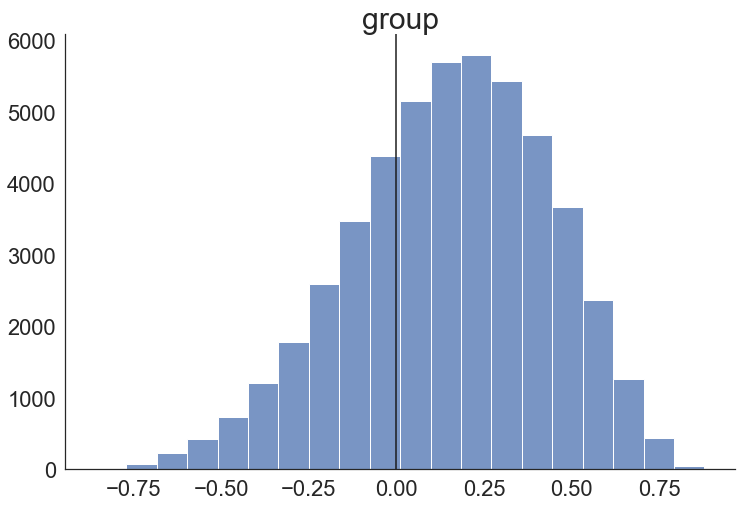

In [204]:

    sns.histplot(data=allpredictDF, x="r",bins=20)
    
    sns.set(font_scale=2) 
    sns.set_style(style='white') 
    sns.despine() 

    plt.title('group',fontsize=30)
    plt.axvline(0,c='k')
    plt.xlabel('')
    plt.ylabel('')

    plt.show()
    plt.close()

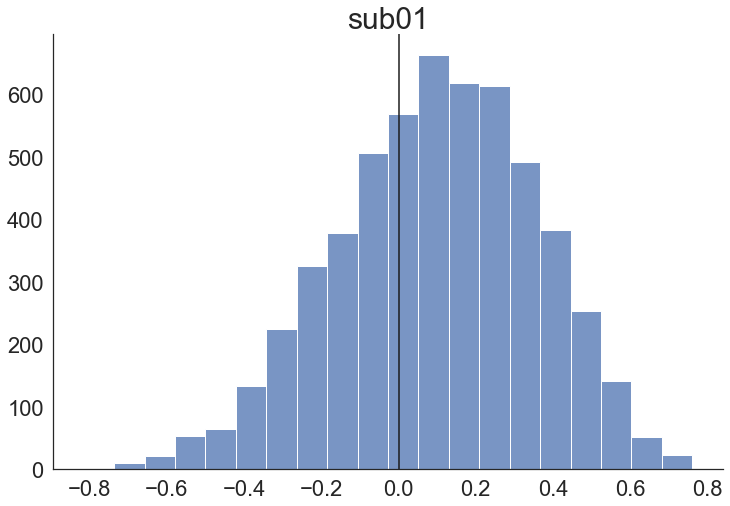

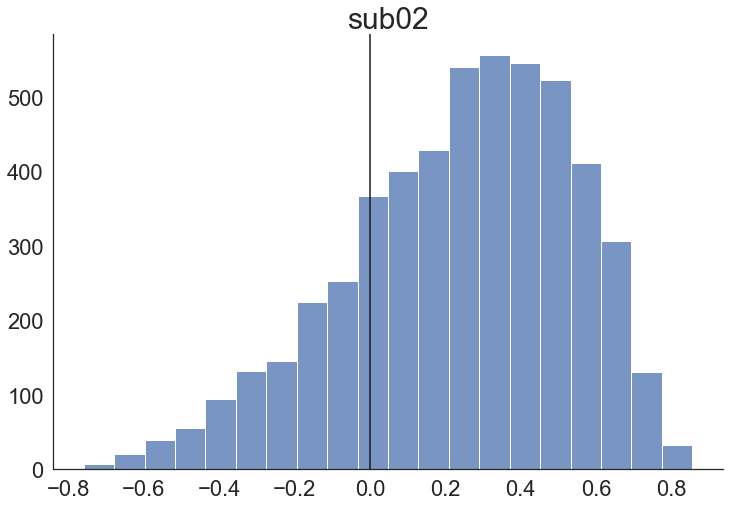

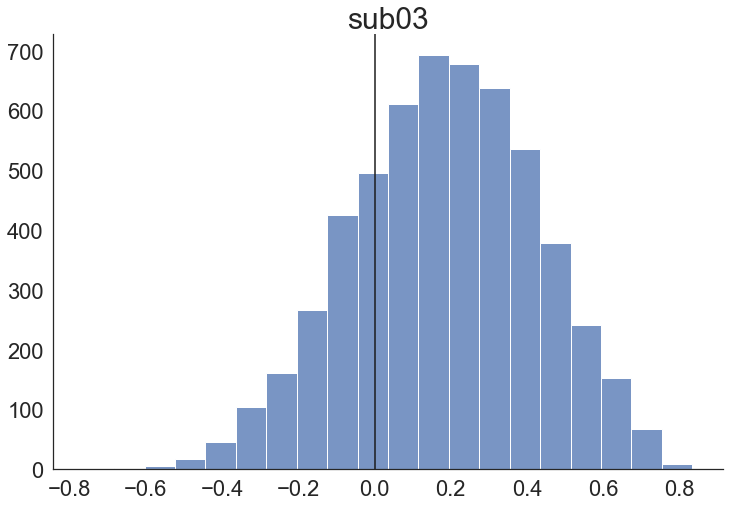

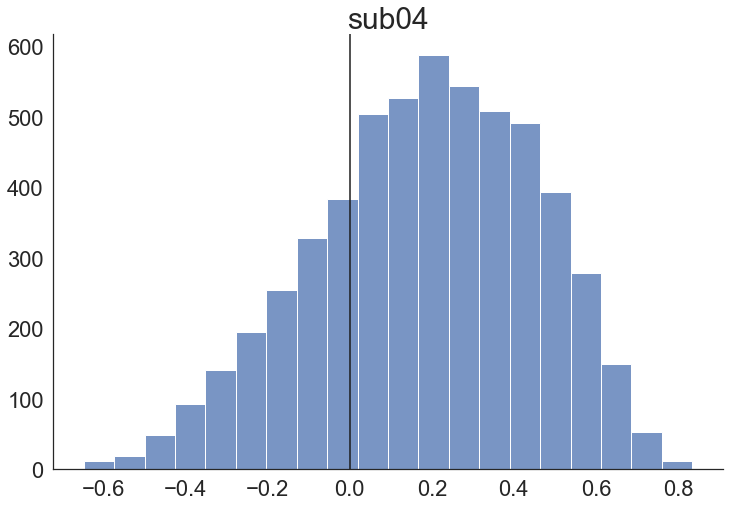

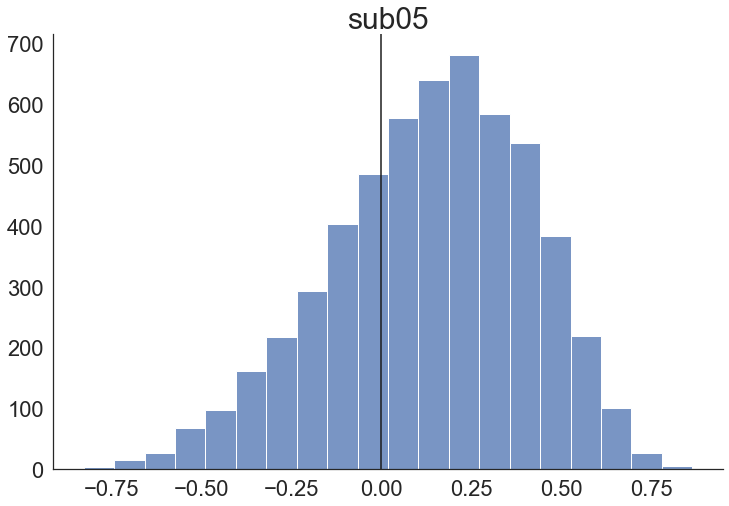

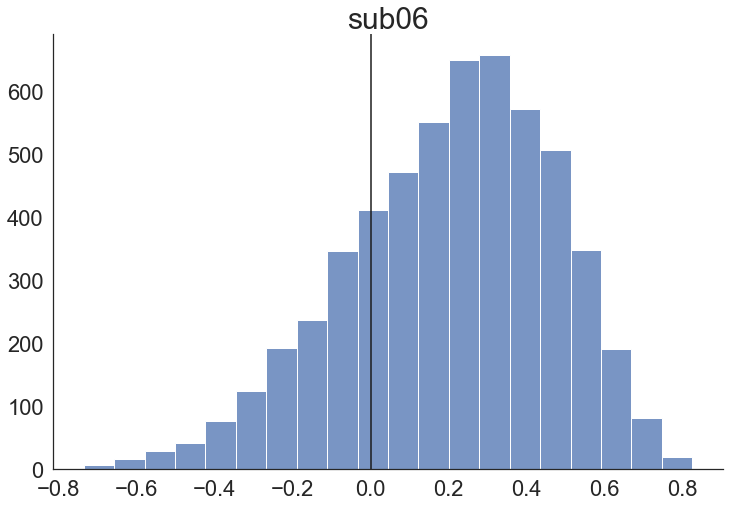

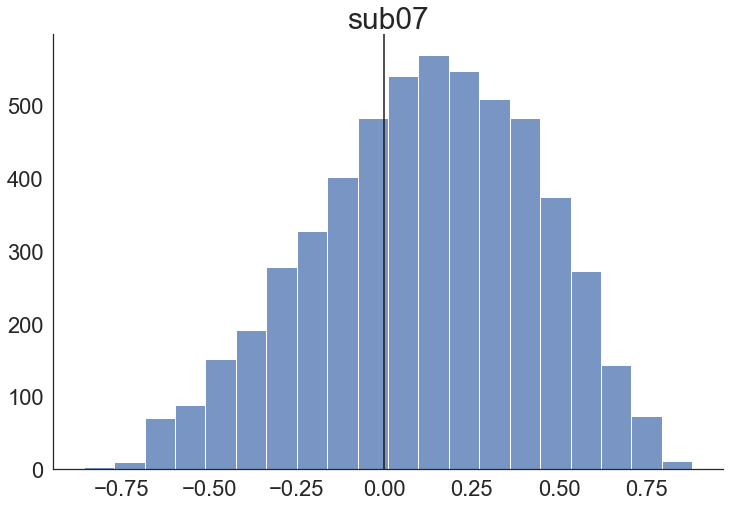

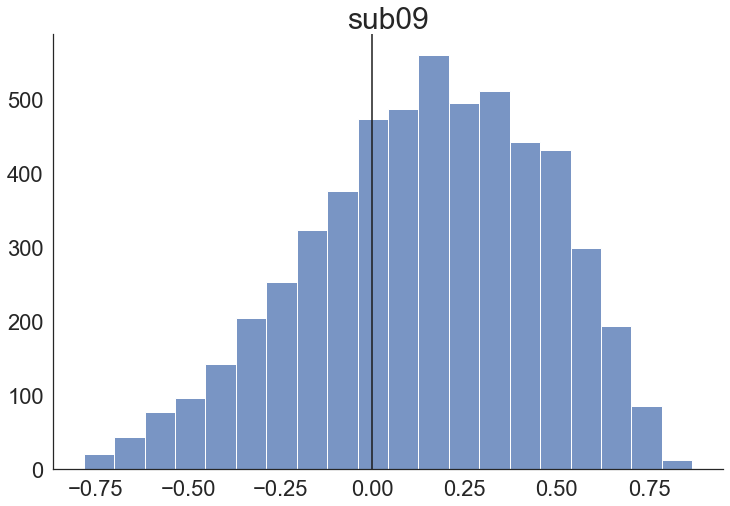

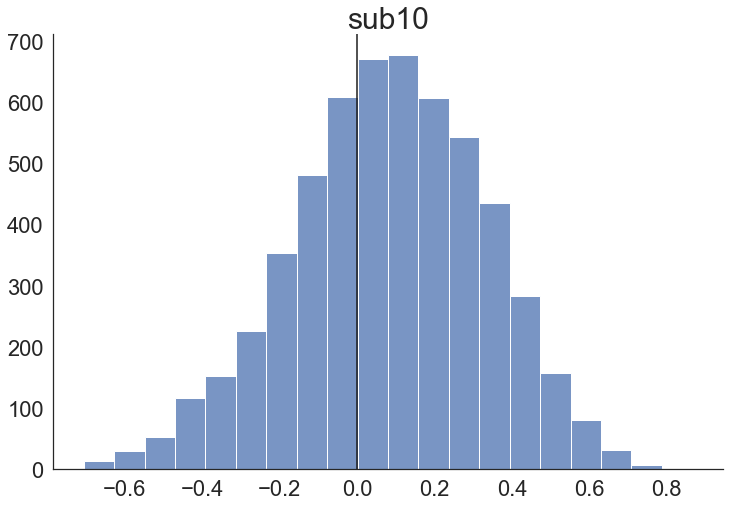

In [205]:
for subid in sublist:

    sns.histplot(data=allpredictDF[allpredictDF['id']==subid], x="r",bins=20)
    
    sns.set(font_scale=2) 
    sns.set_style(style='white') 
    sns.despine() 

    plt.title('sub'+subid,fontsize=30)
    plt.axvline(0,c='k')
    plt.xlabel('')
    plt.ylabel('')

    plt.show()
    plt.close()

## spatial distriution of FC change and communication change

In [194]:
allTaskDF['shared_chg']=allTaskDF['sharedVar']-allTaskDF['sharedVar_mean']
allTaskDF['un1_chg']=allTaskDF['unshared1']-allTaskDF['unshared1_mean']
allTaskDF['un2_chg']=allTaskDF['unshared2']-allTaskDF['unshared2_mean']
edgeSummary=allTaskDF.groupby(['i','j','task','id']).mean()[['corr_chg','comm_chg','shared_chg','un1_chg','un2_chg']].reset_index()
edgeSummary['network']=edgeSummary.apply(lambda r: (labeldict[comlist[int(r['i'])]] if comlist[int(r['i'])]==comlist[int(r['j'])] else 'between'), axis=1)
edgeSummary.head()
    

,i,j,task,id,corr_chg,comm_chg,shared_chg,un1_chg,un2_chg,network
0,0,1,Mem,01,-0.12895,0.09758,-161.37472,-52.05056,-18.92650,between
1,0,1,Mem,02,-0.10515,0.26518,-133.10802,-69.91884,-12.55322,between
2,0,1,Mem,04,-0.12313,-0.24654,-93.31005,-43.99409,-19.65826,between
3,0,1,Mem,06,-0.20002,-0.70134,-230.31493,-38.45527,-7.67630,between
4,0,1,Mem,09,-0.21372,-0.07550,-98.52724,-19.00954,-14.78240,between


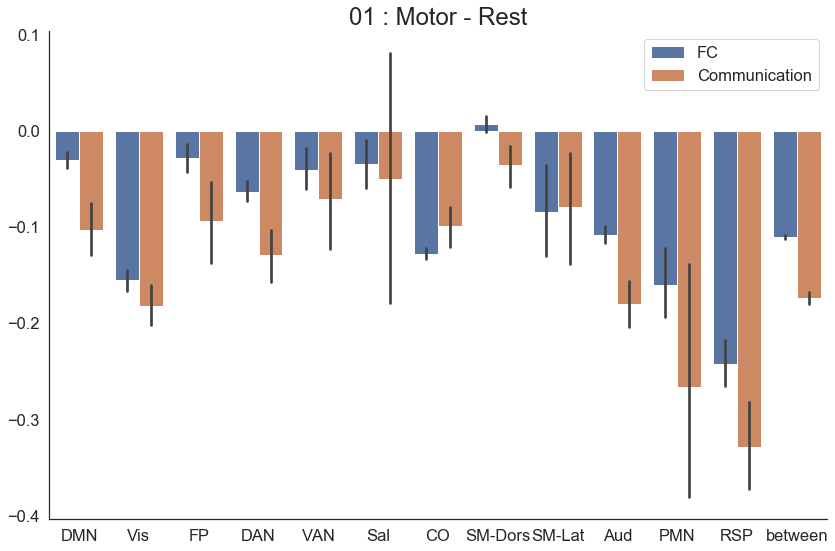

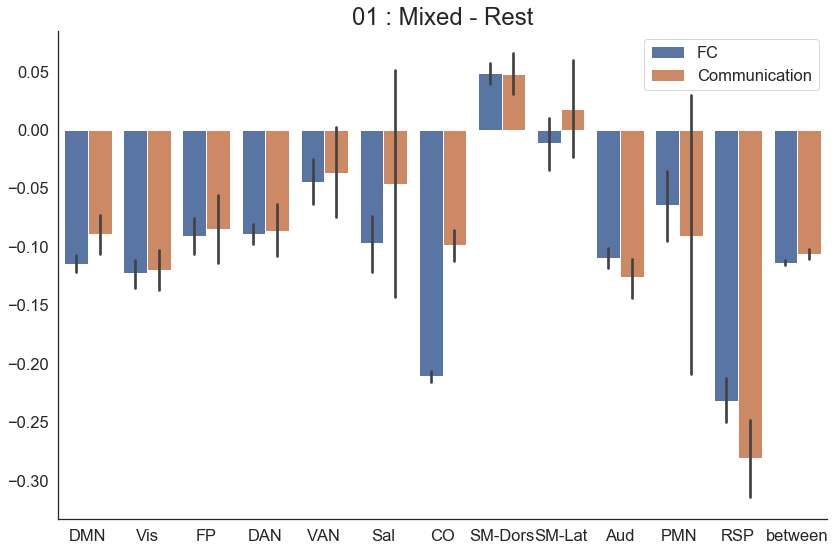

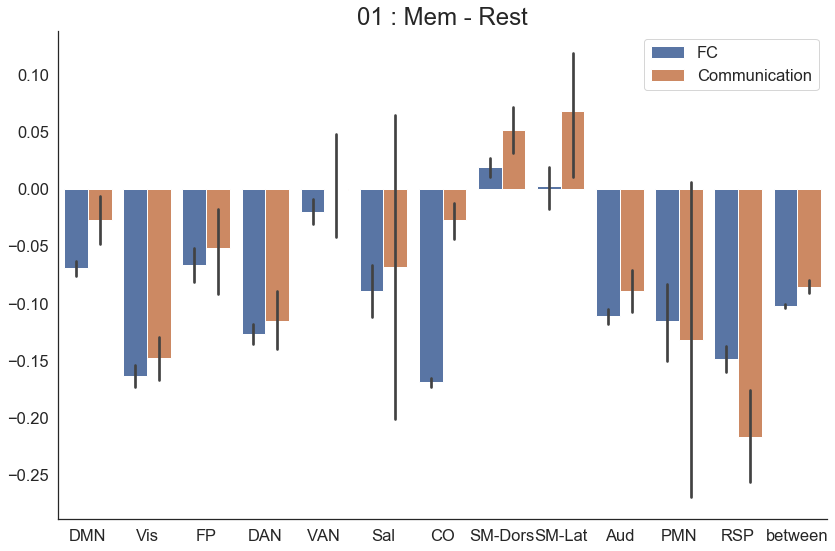

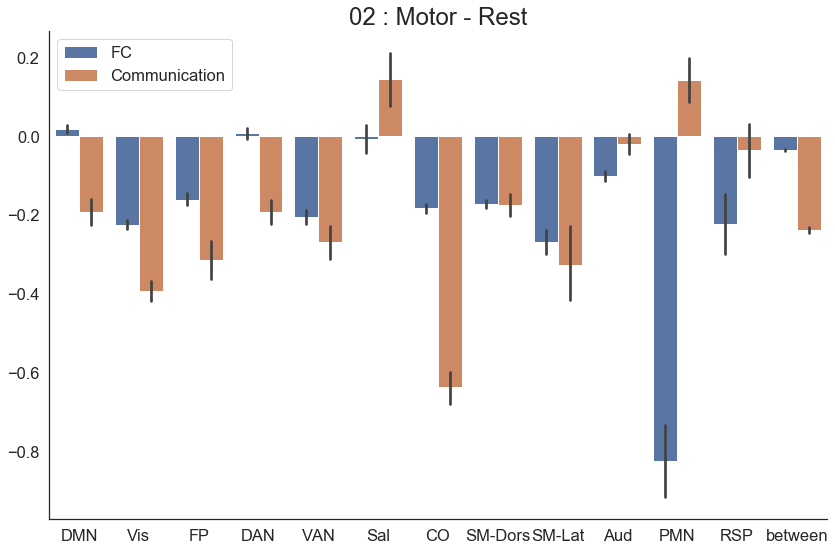

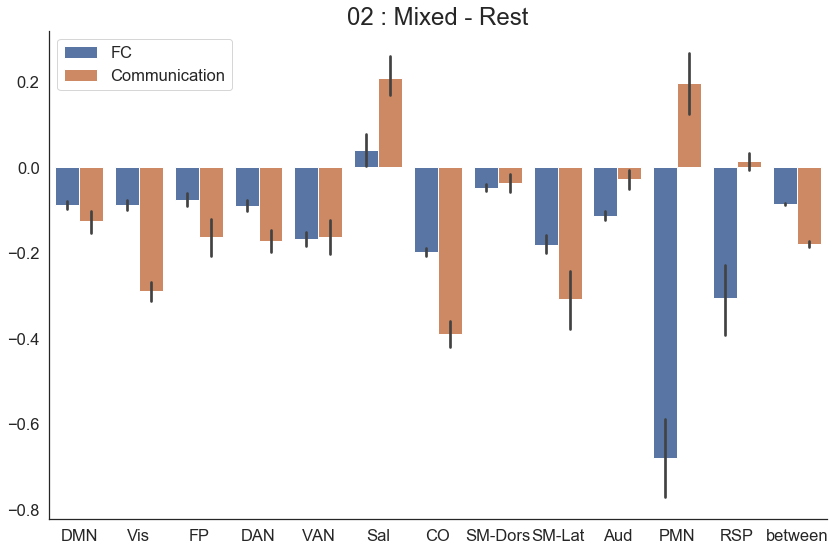

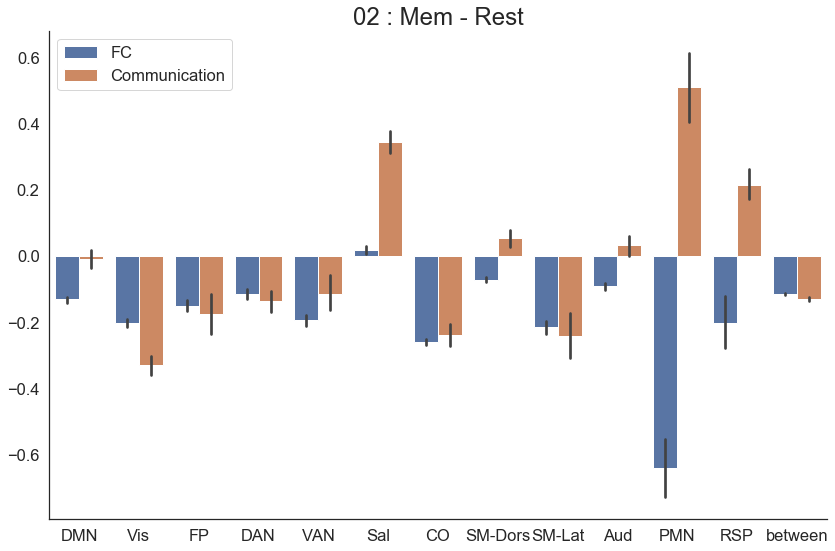

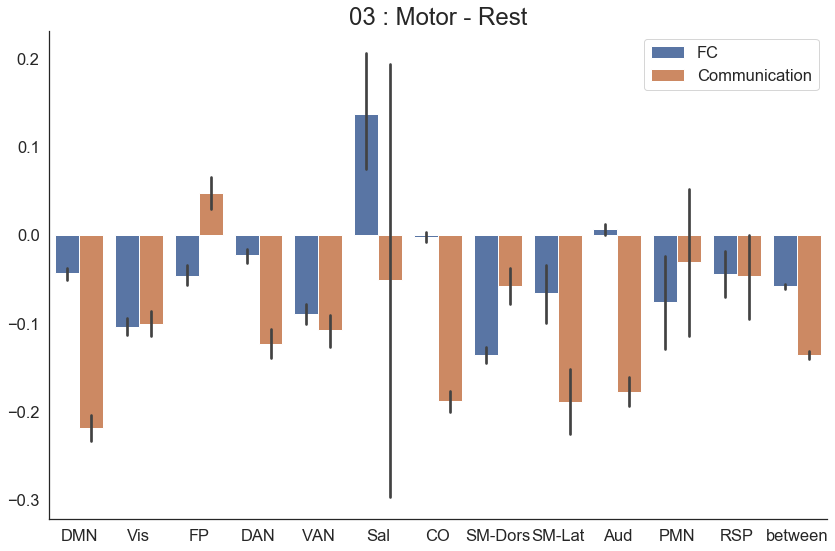

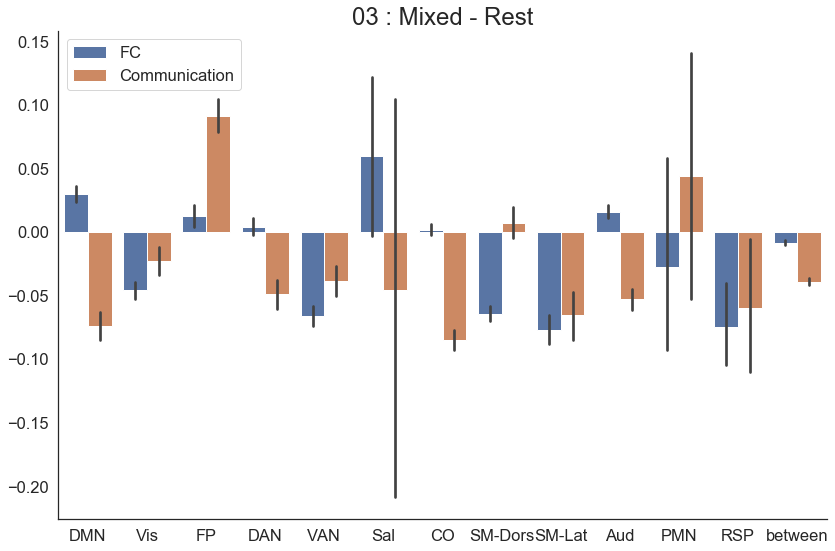

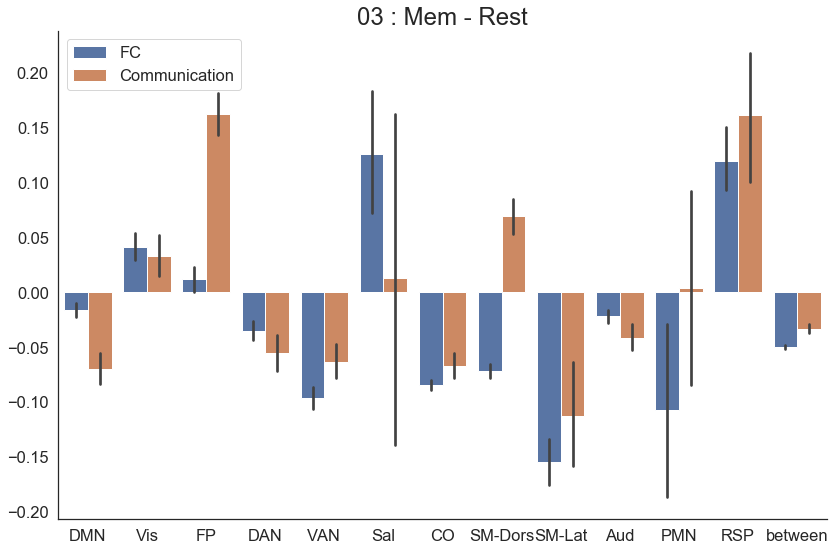

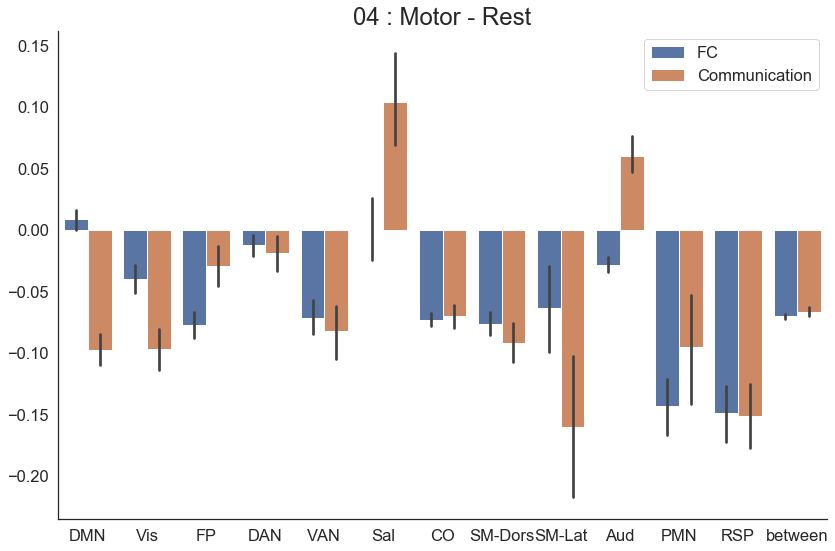

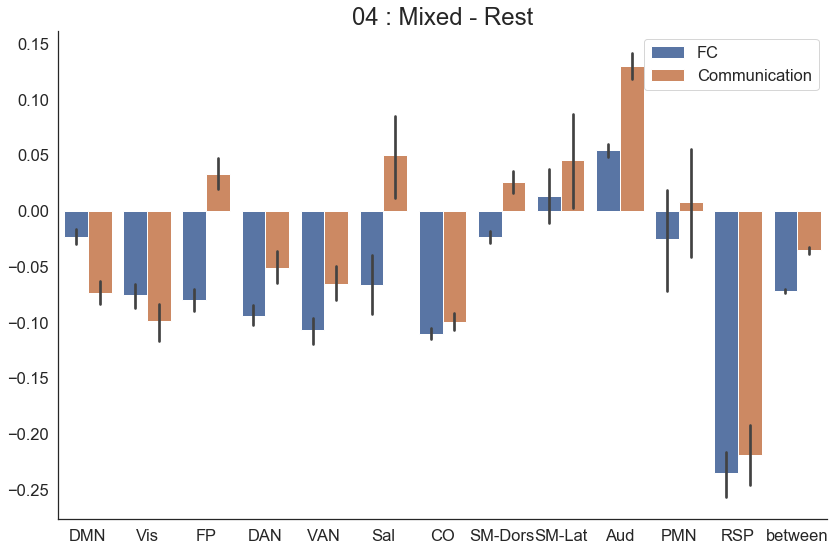

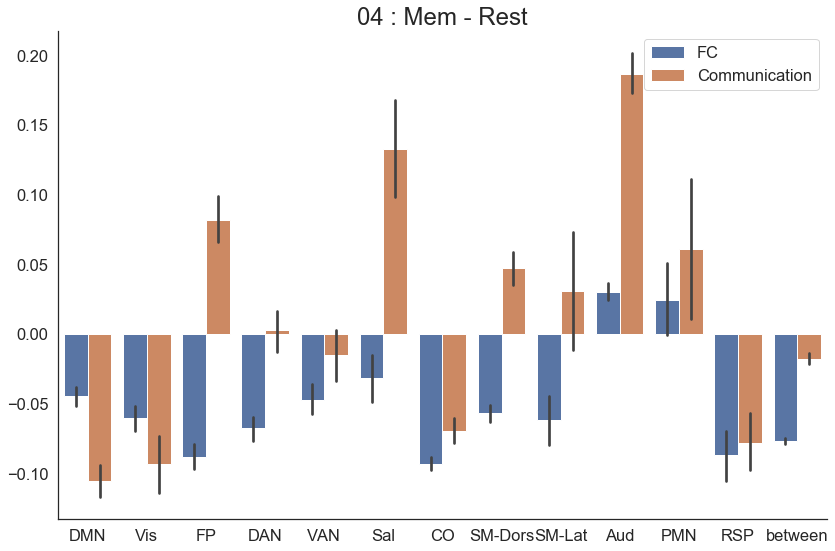

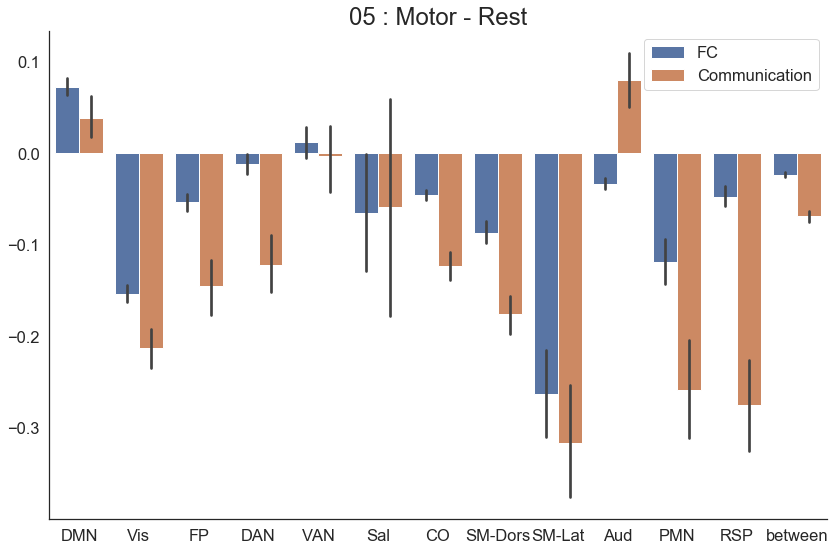

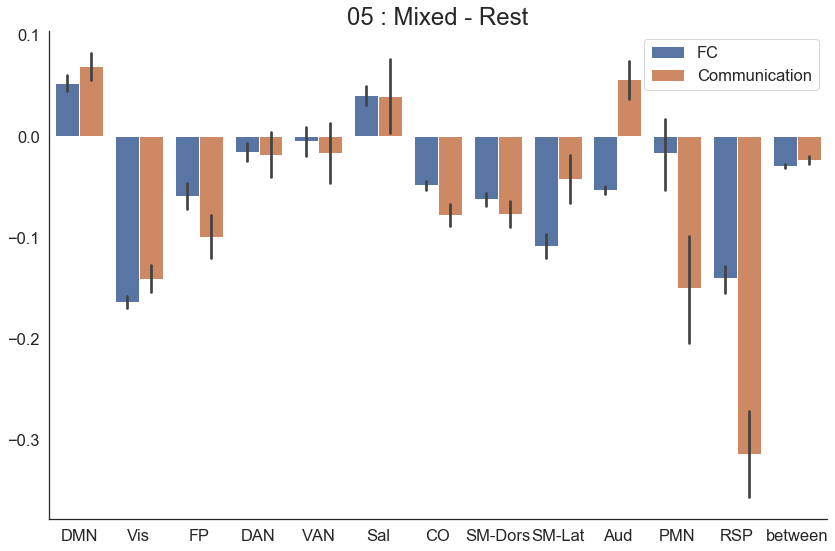

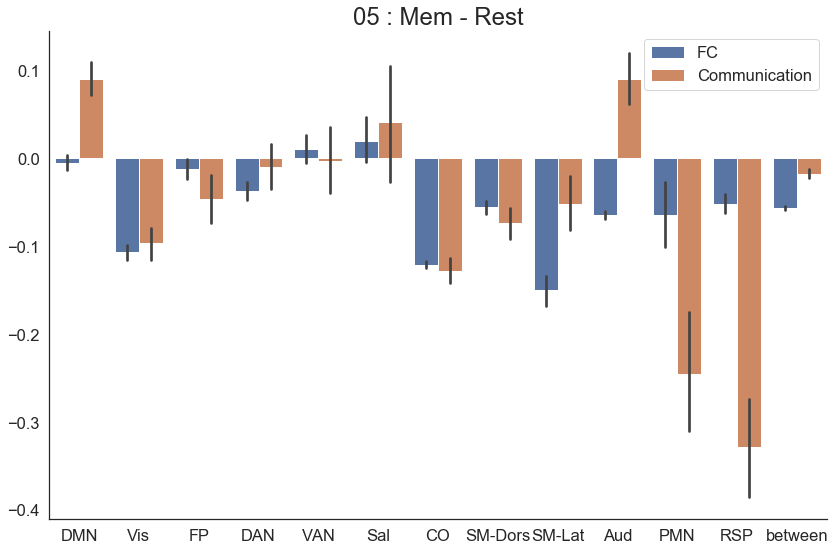

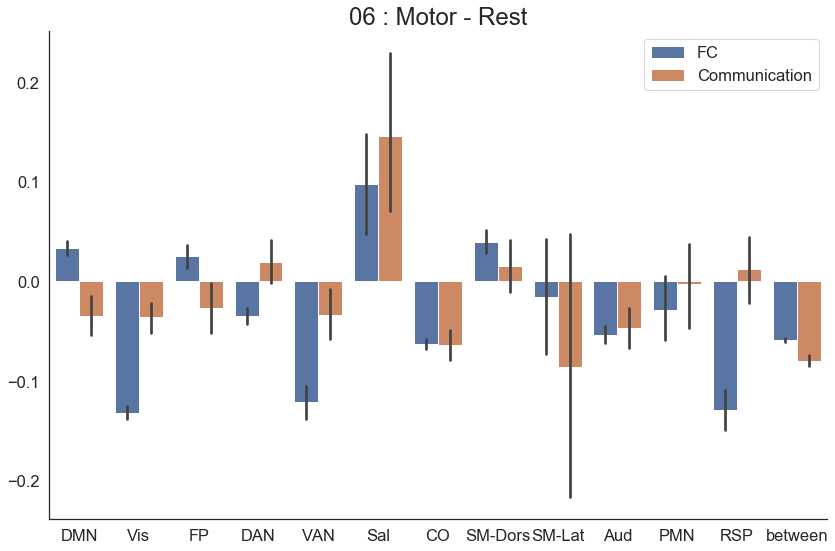

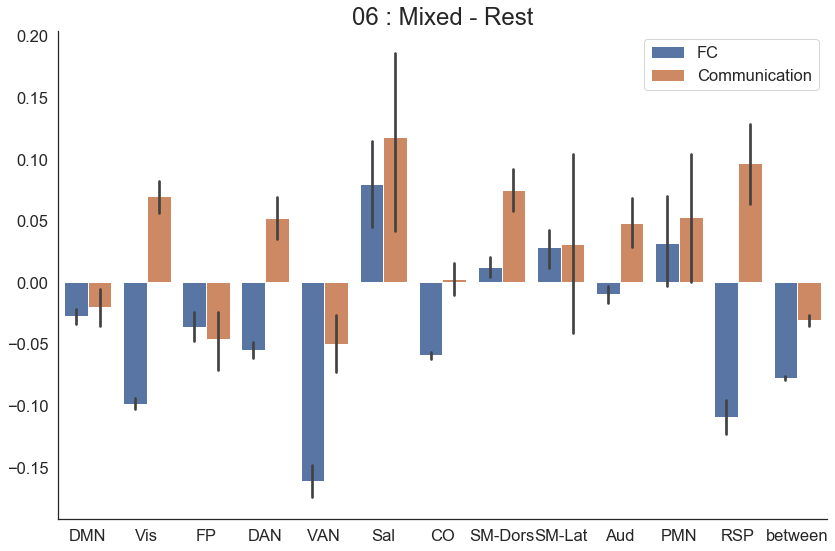

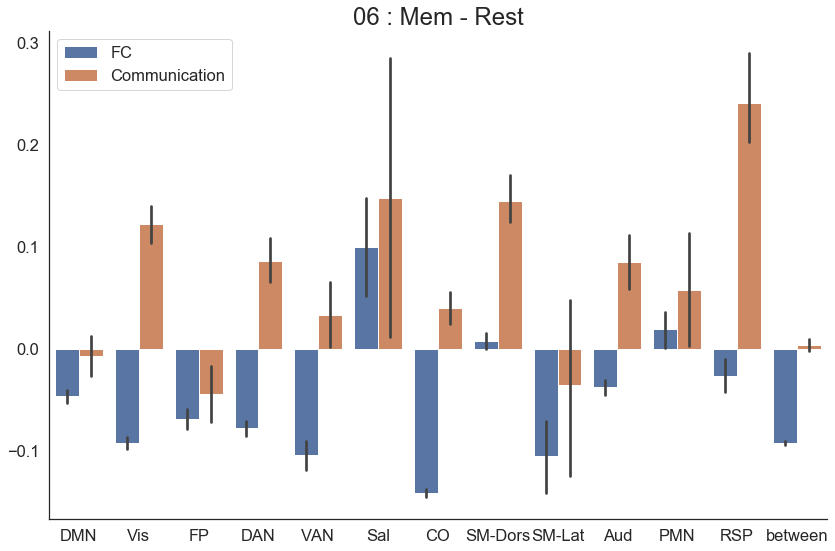

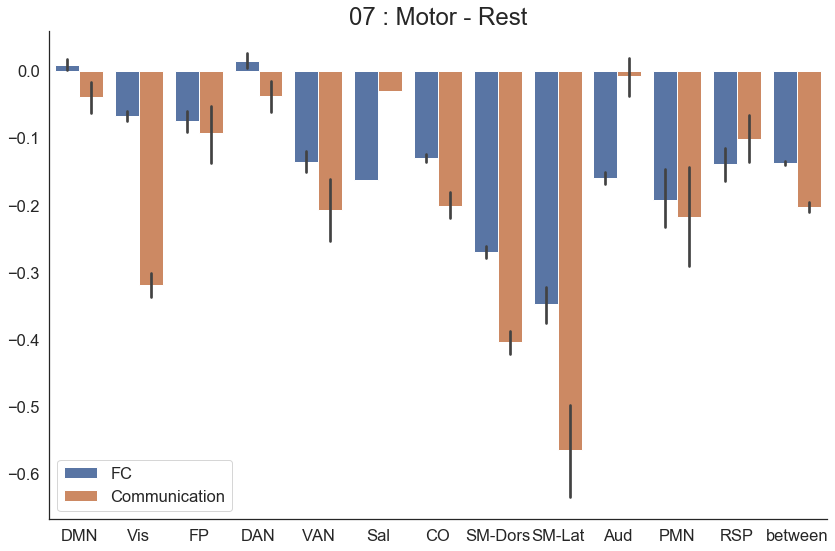

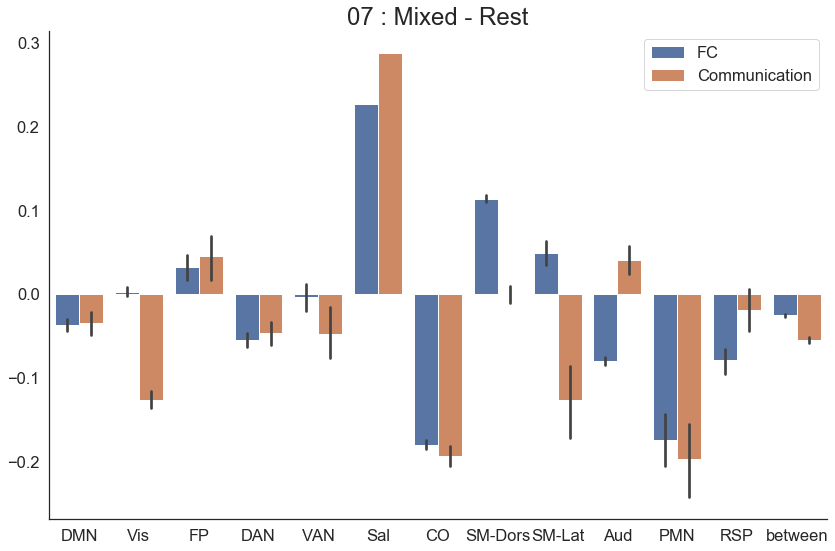

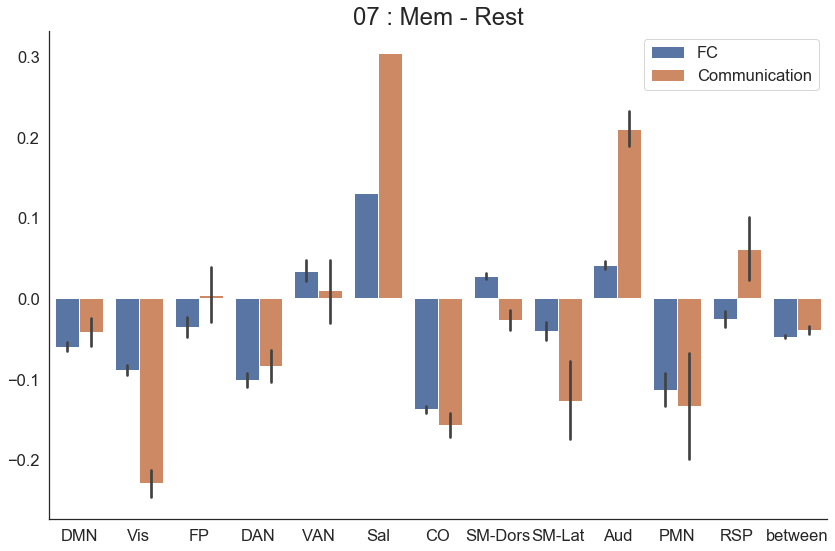

ValueError: min() arg is an empty sequence

In [54]:
for subid in sublist:
    tmp=edgeSummary[edgeSummary['id']==subid]
    for task in ['Motor','Mixed','Mem']:
        g = sns.barplot(x='network',y='value',hue='variable',
                data=pd.melt(tmp[tmp['task']==task], id_vars=['network','i','j'], value_vars=['corr_chg', 'comm_chg']),
                order=np.append(labels,'between'),ci=68)

        g.legend_.set_title(None)
        g.set(xlabel=None,ylabel=None)
        sns.set(font_scale=1.5) 
        sns.set_style(style='white') 
        sns.despine() 
        for t, l in zip(g.legend_.texts, ['FC','Communication']):
            t.set_text(l)
        g.set_title(subid+' : '+task+' - Rest',fontsize=24)
        plt.tight_layout()
        plt.show()
        plt.close()

In [206]:
#group avearage
allTaskDF['shared_chg']=allTaskDF['sharedVar']-allTaskDF['sharedVar_mean']
allTaskDF['un1_chg']=allTaskDF['unshared1']-allTaskDF['unshared1_mean']
allTaskDF['un2_chg']=allTaskDF['unshared2']-allTaskDF['unshared2_mean']
edgeSummary=allTaskDF.groupby(['i','j','task']).mean()[['corr_chg','comm_chg','shared_chg','un1_chg','un2_chg']].reset_index()
edgeSummary['network']=edgeSummary.apply(lambda r: (labeldict[comlist[int(r['i'])]] if comlist[int(r['i'])]==comlist[int(r['j'])] else 'between'), axis=1)
edgeSummary.head()

,i,j,task,corr_chg,comm_chg,shared_chg,un1_chg,un2_chg,network
0,0,1,Mem,-0.20687,-0.11108,-69.98470,-38.99861,-14.02480,between
1,0,1,Mixed,-0.07992,-0.07631,-43.16603,-27.76499,-9.80425,between
2,0,1,Motor,0.07167,-0.15221,-44.38205,-55.91717,-11.32000,between
3,0,1,Rest,0.00000,-0.00000,0.00000,-0.00000,-0.00000,between
4,0,3,Mem,-0.02375,0.27927,-83.40862,-45.61485,-21.75399,DMN


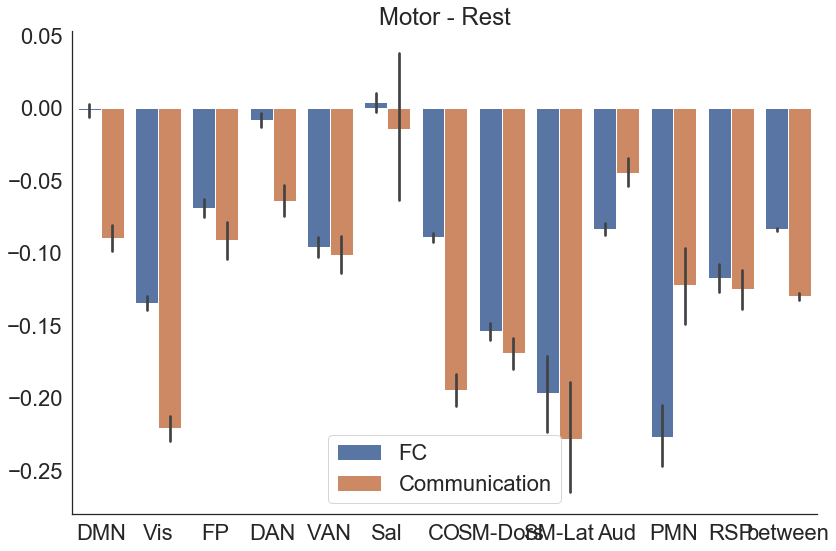

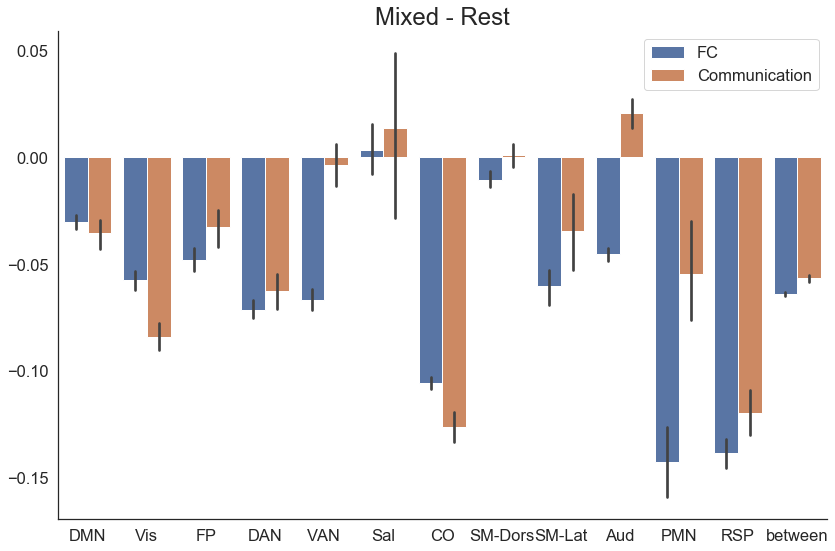

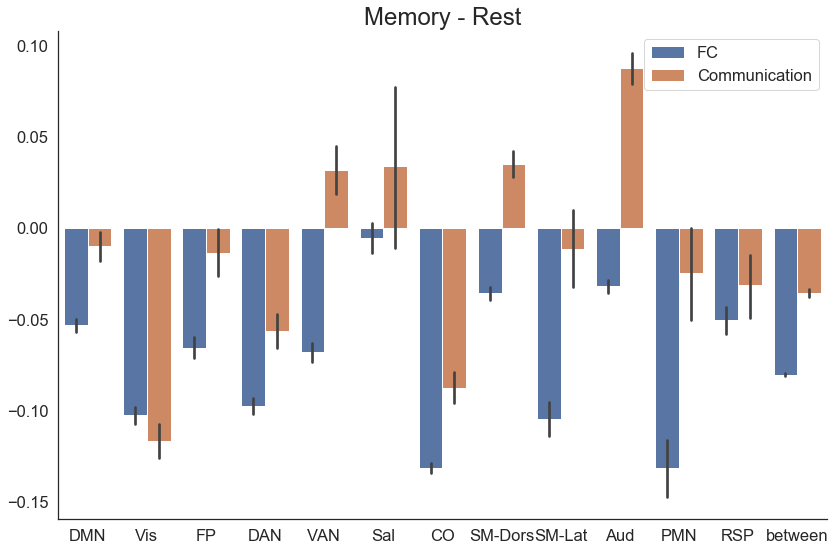

In [207]:
for task in ['Motor','Mixed','Mem']:
    g = sns.barplot(x='network',y='value',hue='variable',
            data=pd.melt(edgeSummary[edgeSummary['task']==task], id_vars=['network','i','j'], value_vars=['corr_chg', 'comm_chg']),
            order=np.append(labels,'between'),ci=68)

    g.legend_.set_title(None)
    g.set(xlabel=None,ylabel=None)
    sns.set(font_scale=1.5) 
    sns.set_style(style='white') 
    sns.despine() 
    for t, l in zip(g.legend_.texts, ['FC','Communication']):
        t.set_text(l)
    g.set_title((task+' - Rest').replace('Mem','Memory'),fontsize=24)
    plt.tight_layout()
    plt.show()
    plt.close()

# communication change discriminate task type

In [198]:
import random
import pingouin as pg
#ICC1k
#interpreted as the % of total variance accounted for by subjects/items variance. This is called the consistency ICC.

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.11, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [208]:
#compute ICC
for subid in sublist:
    print(subid)
    subTaskDF=pd.DataFrame()
    tasklist=['Mem','Motor','Rest','Mixed']
    if subid=='09':
        tasklist=['Mem','Rest','Mixed']
    for task in tasklist:
        tmp=pd.read_csv(sourcefolder+'processed/'+task+'_'+subid+'_comm_10pct.csv')
        tmp['task']=task
        tmp['id']=subid
        subTaskDF=pd.concat([subTaskDF,tmp])
    subTaskDF['predict']=subTaskDF['corr_chg']-subTaskDF['comm_chg']

    iccDF=[]
    varname='comm_chg'
    for r,g in subTaskDF.groupby(['i','j']):
        if len(g.dropna())<0.9*len(g):
            continue #more than 10%missing
        g[varname] = g[varname].apply(lambda x: random.choice(g[varname].dropna().values) if np.isnan(x) else x)
        tmp=pg.intraclass_corr(data=g,
                   targets='task', raters='session',ratings=varname)
        tmp=tmp.loc[tmp['Type']=='ICC1k',['ICC','F','pval']].values
        iccDF.append(list(r)+tmp.tolist()[0])
    iccDF=pd.DataFrame(iccDF,columns=['i','j','ICC','F','pval'])
    iccDF_corr=[]
    varname='corr_chg'
    for r,g in subTaskDF.groupby(['i','j']):
        if len(g.dropna())<0.9*len(g):
            continue #more than 10%missing
        g[varname] = g[varname].apply(lambda x: random.choice(g[varname].dropna().values) if np.isnan(x) else x)
        tmp=pg.intraclass_corr(data=g,
                   targets='task', raters='session',ratings=varname)
        tmp=tmp.loc[tmp['Type']=='ICC1k',['ICC','F','pval']].values
        iccDF_corr.append(list(r)+tmp.tolist()[0])
    iccDF_corr=pd.DataFrame(iccDF_corr,columns=['i','j','ICC','F','pval'])    
    iccDF=iccDF.drop(['F'],axis=1).rename(columns={'ICC':'ICC_comm','pval':'pval_comm'}).merge(iccDF_corr.rename(columns={'ICC':'ICC_corr','pval':'pval_corr'}).drop(['F'],axis=1),
            left_on=['i','j'],right_on=['i','j'],how='outer')
    iccDF.to_csv(sourcefolder+'processed/'+'TaskICC'+'_'+subid+'_10pct.csv',index=False)

01


/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pingouin/reliability.py:364: RuntimeWarning: invalid value encountered in double_scalars
  n * msb)
/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


02
03
04
05
07
09
10


In [40]:
#compute ICC without the rest state
#for subid in ['06']:
for subid in sublist:
    print(subid)
    subTaskDF=pd.DataFrame()
    tasklist=['Mem','Motor','Mixed']
    if subid=='09':
        tasklist=['Mem','Mixed']
    for task in tasklist:
        tmp=pd.read_csv(sourcefolder+'processed/'+task+'_'+subid+'_comm.csv')
        tmp['task']=task
        tmp['id']=subid
        subTaskDF=pd.concat([subTaskDF,tmp])
    subTaskDF['predict']=subTaskDF['corr_chg']-subTaskDF['comm_chg']

    iccDF=[]
    varname='comm_chg'
    for r,g in subTaskDF.groupby(['i','j']):
        if len(g.dropna())<0.9*len(g):
            continue #more than 10%missing
        g[varname] = g[varname].apply(lambda x: random.choice(g[varname].dropna().values) if np.isnan(x) else x)
        tmp=pg.intraclass_corr(data=g,
                   targets='task', raters='session',ratings=varname)
        tmp=tmp.loc[tmp['Type']=='ICC1k',['ICC','F','pval']].values
        iccDF.append(list(r)+tmp.tolist()[0])
    iccDF=pd.DataFrame(iccDF,columns=['i','j','ICC','F','pval'])
    iccDF_corr=[]
    varname='corr_chg'
    for r,g in subTaskDF.groupby(['i','j']):
        if len(g.dropna())<0.9*len(g):
            continue #more than 10%missing
        g[varname] = g[varname].apply(lambda x: random.choice(g[varname].dropna().values) if np.isnan(x) else x)
        tmp=pg.intraclass_corr(data=g,
                   targets='task', raters='session',ratings=varname)
        tmp=tmp.loc[tmp['Type']=='ICC1k',['ICC','F','pval']].values
        iccDF_corr.append(list(r)+tmp.tolist()[0])
    iccDF_corr=pd.DataFrame(iccDF_corr,columns=['i','j','ICC','F','pval'])    
    iccDF=iccDF.drop(['F'],axis=1).rename(columns={'ICC':'ICC_comm','pval':'pval_comm'}).merge(iccDF_corr.rename(columns={'ICC':'ICC_corr','pval':'pval_corr'}).drop(['F'],axis=1),
            left_on=['i','j'],right_on=['i','j'],how='outer')
    iccDF.to_csv(sourcefolder+'processed/'+'3TaskICC'+'_'+subid+'.csv',index=False)

01


/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pingouin/reliability.py:364: RuntimeWarning: invalid value encountered in double_scalars
  n * msb)
/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


02
03
04
05
07
09
10


In [21]:
iccDF.describe()

,i,j,ICC_comm,pval_comm,ICC_corr,pval_corr
count,5528.00000,5528.00000,5528.00000,5528.00000,5528.00000,5528.00000
mean,114.66444,217.30192,-17.52317,0.23127,-2.98661,0.35626
std,82.53386,81.60883,1173.90495,0.27339,24.50157,0.29792
min,0.00000,1.00000,-87146.17136,0.00000,-785.03857,0.00000
25%,43.00000,157.00000,0.00073,0.01305,-0.87554,0.08516
50%,100.00000,233.00000,0.59064,0.10589,0.23667,0.28641
75%,180.00000,278.00000,0.80458,0.38084,0.62995,0.59279
max,330.00000,332.00000,0.98482,0.99999,0.95586,0.99873


In [61]:
#plotgroup
iccDF=pd.DataFrame()
for subid in sublist:
    iccDF=pd.concat([iccDF,pd.read_csv(sourcefolder+'processed/'+'TaskICC'+'_'+subid+'.csv',index_col=None)])



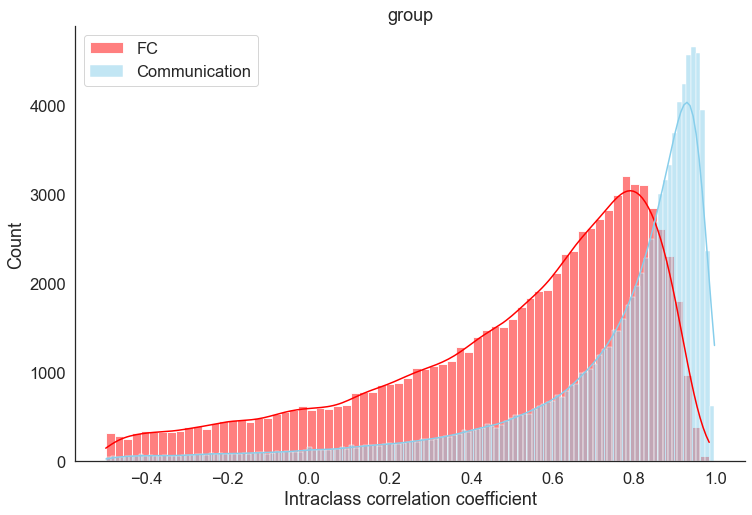

In [210]:
ax=sns.histplot(data=iccDF[iccDF['ICC_corr']>-.5], x="ICC_corr", color="red", label="FC", kde=True)
sns.histplot(data=iccDF[iccDF['ICC_comm']>-.5], x="ICC_comm", color="skyblue", label="Communication", kde=True)
#ax.set(xlabel='Intraclass Correlation Coefficient',title=subid)
ax.set(title='group',xlabel='Intraclass correlation coefficient')
sns.set(font_scale=1.5) 
sns.set_style(style='white') 
sns.despine() 
plt.legend() 
plt.show()
plt.close()

In [64]:
#clip the negative ICC to compute statistics for reporting
iccDF[['ICC_comm_clip','ICC_corr_clip']]=iccDF[['ICC_comm','ICC_corr']].clip(lower=0)
print(iccDF.mean()[['ICC_comm_clip','ICC_corr_clip']])
print(iccDF.std()[['ICC_comm_clip','ICC_corr_clip']]/np.sqrt(len(iccDF)))

ICC_comm_clip   0.69929
ICC_corr_clip   0.46262
dtype: float64
ICC_comm_clip   0.00137
ICC_corr_clip   0.00149
dtype: float64


In [67]:
len(iccDF[iccDF['pval_comm']<.05])/len(iccDF)

0.7051326144571001

In [68]:
#t-stat
(iccDF['ICC_comm_clip']-iccDF['ICC_corr_clip']).mean()/(iccDF['ICC_comm_clip']-iccDF['ICC_corr_clip']).std()*np.sqrt(len(iccDF))

140.22879443733444

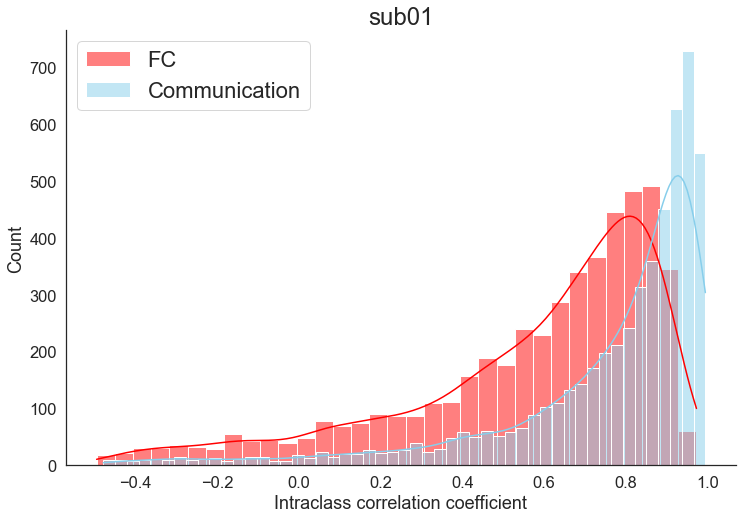

ICC_comm   0.72795
ICC_corr   0.52331
dtype: float64
ICC_comm   0.00387
ICC_corr   0.00428
dtype: float64


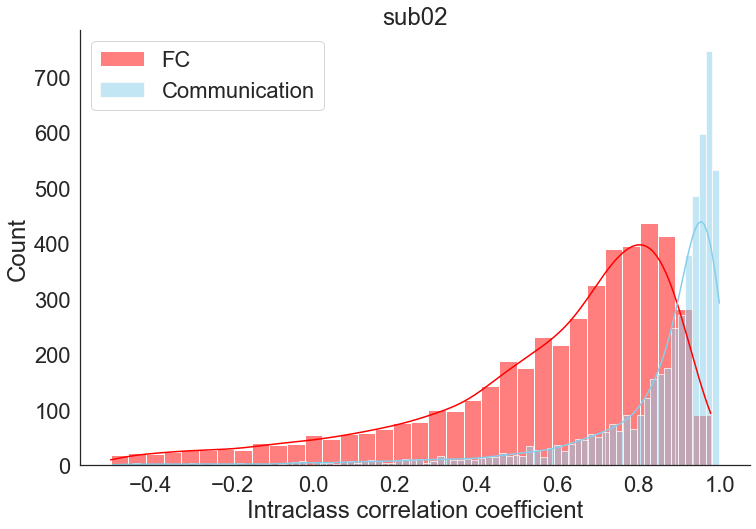

ICC_comm   0.82796
ICC_corr   0.52574
dtype: float64
ICC_comm   0.00318
ICC_corr   0.00443
dtype: float64


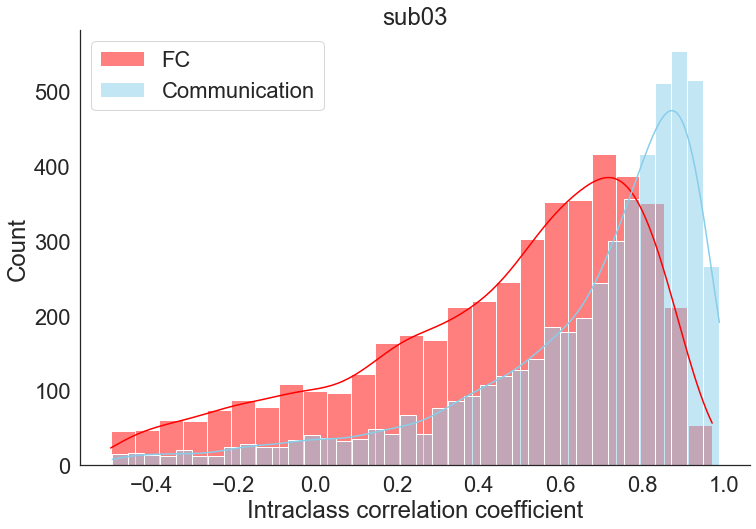

ICC_comm   0.61354
ICC_corr   0.38570
dtype: float64
ICC_comm   0.00428
ICC_corr   0.00430
dtype: float64


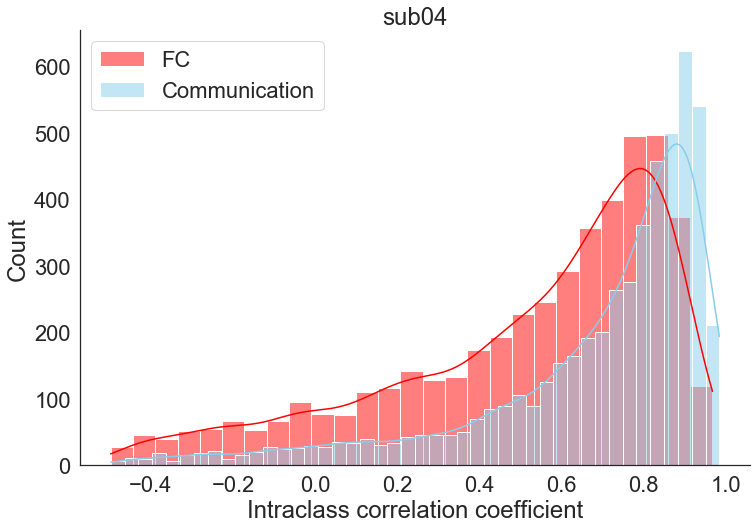

ICC_comm   0.65280
ICC_corr   0.45570
dtype: float64
ICC_comm   0.00409
ICC_corr   0.00450
dtype: float64


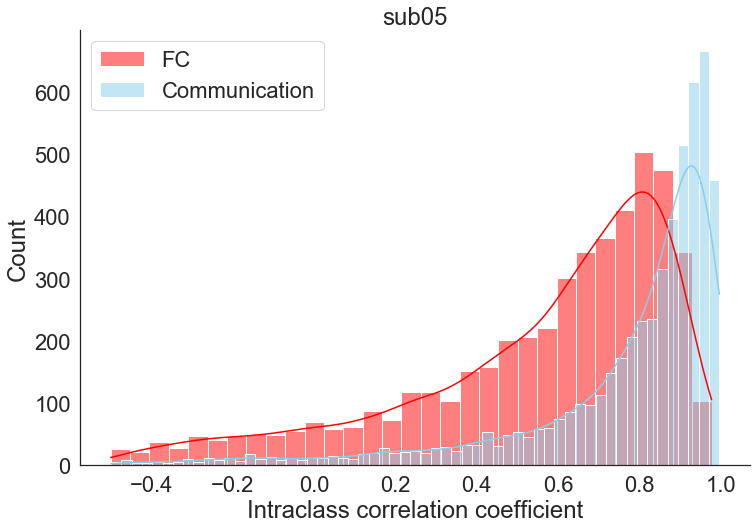

ICC_comm   0.74295
ICC_corr   0.50718
dtype: float64
ICC_comm   0.00381
ICC_corr   0.00438
dtype: float64


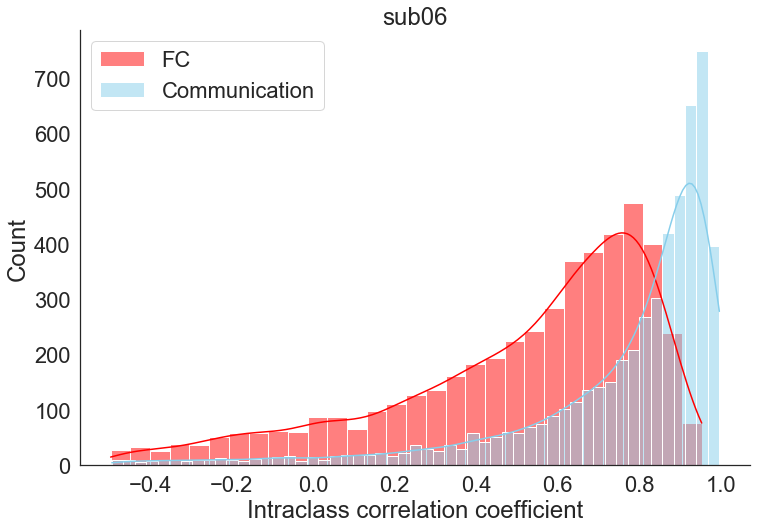

ICC_comm   0.73308
ICC_corr   0.46076
dtype: float64
ICC_comm   0.00380
ICC_corr   0.00424
dtype: float64


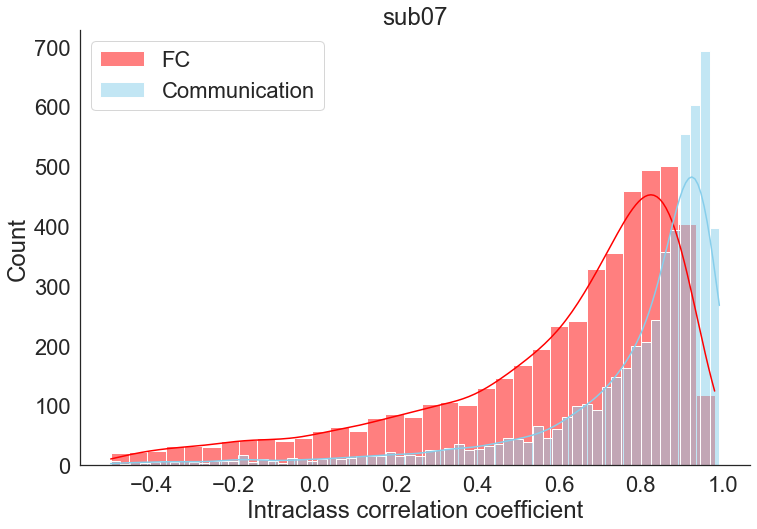

ICC_comm   0.74996
ICC_corr   0.53162
dtype: float64
ICC_comm   0.00370
ICC_corr   0.00445
dtype: float64


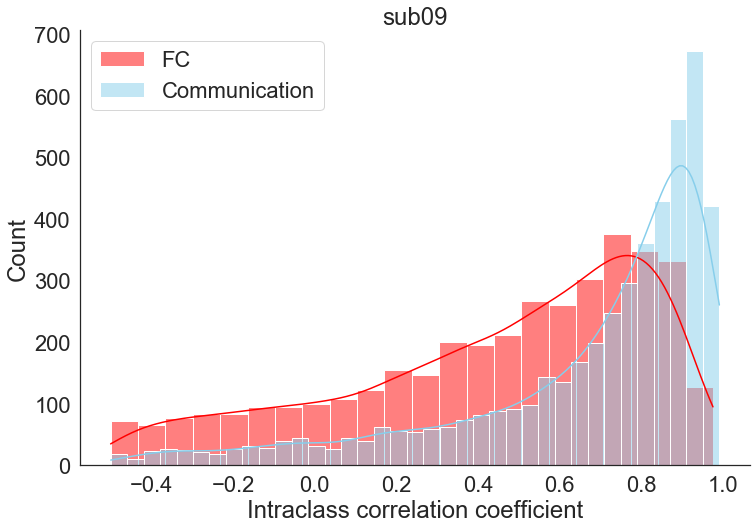

ICC_comm   0.59538
ICC_corr   0.32884
dtype: float64
ICC_comm   0.00476
ICC_corr   0.00455
dtype: float64


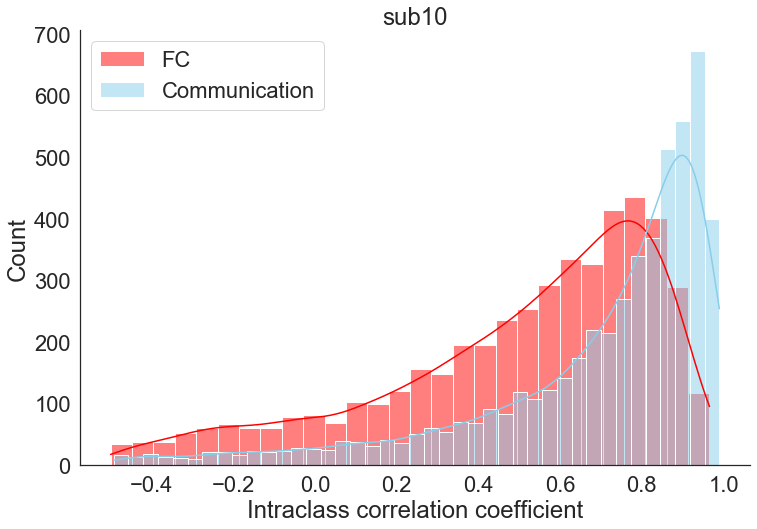

ICC_comm   0.65728
ICC_corr   0.44820
dtype: float64
ICC_comm   0.00421
ICC_corr   0.00435
dtype: float64


In [169]:
sns.set(font_scale=2) 
for subid in sublist:
    #iccDF=pd.read_csv(sourcefolder+'processed/'+'3TaskICC'+'_'+subid+'.csv',index_col=None)
    iccDF=pd.read_csv(sourcefolder+'processed/'+'TaskICC'+'_'+subid+'.csv',index_col=None)
    ax=sns.histplot(data=iccDF[iccDF['ICC_corr']>-.5], x="ICC_corr", color="red", label="FC", kde=True)
    sns.histplot(data=iccDF[iccDF['ICC_comm']>-.5], x="ICC_comm", color="skyblue", label="Communication", kde=True)
    #ax.set(xlabel='Intraclass Correlation Coefficient',title=subid)
    
    ax.set(title='sub'+subid)
    ax.set(xlabel='Intraclass correlation coefficient')

    sns.set_style(style='white') 
    sns.despine() 
    plt.legend() 
    plt.show()
    plt.close
    iccDF[['ICC_comm','ICC_corr']]=iccDF[['ICC_comm','ICC_corr']].clip(lower=0)
    print(iccDF.mean()[['ICC_comm','ICC_corr']])
    print(iccDF.std()[['ICC_comm','ICC_corr']]/np.sqrt(len(iccDF)))
    